### Importing Modules

In [ ]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

### Setting the hyperparameters

In [ ]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.01
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS 
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"

### Patch Embedding with position embedding

In [ ]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x

model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)

torch.Size([512, 50, 16])


### VIT implementation with encoder and MLP

In [ ]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :]) 
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape) 

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


torch.Size([512, 10])


### Dataset Preparation

In [8]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

In [ ]:
train_df.head()

In [ ]:
test_df.head()

In [18]:
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)

### Train Dataset

In [16]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTtestDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "index": index}

### Train Data Plot

11871
{'image': tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
          -1.0000, -1.0000, -1.0

<ipython-input-19-d9ff9b328ce6>:4: RuntimeWarning: invalid value encountered in cast
  train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
<ipython-input-19-d9ff9b328ce6>:18: RuntimeWarning: invalid value encountered in cast
  test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)


<Figure size 640x480 with 0 Axes>

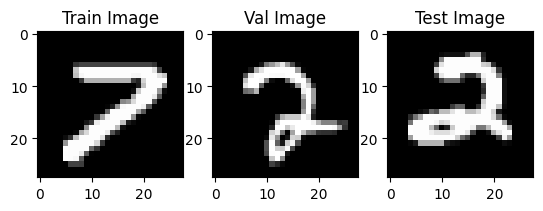

In [19]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print(len(train_dataset))
print(train_dataset[0])
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print(len(val_dataset))
print(val_dataset[0])
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTtestDataset(test_df.values.astype(np.uint8), test_df.index.values)
print(len(test_dataset))
print(test_dataset[0])
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

plt.show()

In [20]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

### Training the model

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)

stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")

  2%|▎         | 1/40 [03:40<2:23:31, 220.80s/it]

------------------------------
Train Loss EPOCH 1: 2.3160
Valid Loss EPOCH 1: 2.2876
Train Accuracy EPOCH 1: 0.1237
Valid Accuracy EPOCH 1: 0.1941
------------------------------


  5%|▌         | 2/40 [07:30<2:22:58, 225.75s/it]

------------------------------
Train Loss EPOCH 2: 2.2464
Valid Loss EPOCH 2: 2.1421
Train Accuracy EPOCH 2: 0.2046
Valid Accuracy EPOCH 2: 0.2502
------------------------------


  8%|▊         | 3/40 [11:11<2:17:53, 223.61s/it]

------------------------------
Train Loss EPOCH 3: 2.1075
Valid Loss EPOCH 3: 2.0423
Train Accuracy EPOCH 3: 0.2449
Valid Accuracy EPOCH 3: 0.2684
------------------------------


 10%|█         | 4/40 [14:51<2:13:19, 222.20s/it]

------------------------------
Train Loss EPOCH 4: 1.9917
Valid Loss EPOCH 4: 1.8585
Train Accuracy EPOCH 4: 0.3012
Valid Accuracy EPOCH 4: 0.3783
------------------------------


 12%|█▎        | 5/40 [18:52<2:13:40, 229.15s/it]

------------------------------
Train Loss EPOCH 5: 1.8271
Valid Loss EPOCH 5: 1.7141
Train Accuracy EPOCH 5: 0.3645
Valid Accuracy EPOCH 5: 0.4026
------------------------------


 15%|█▌        | 6/40 [22:29<2:07:29, 224.98s/it]

------------------------------
Train Loss EPOCH 6: 1.7296
Valid Loss EPOCH 6: 1.6635
Train Accuracy EPOCH 6: 0.4108
Valid Accuracy EPOCH 6: 0.4428
------------------------------


 18%|█▊        | 7/40 [26:17<2:04:12, 225.84s/it]

------------------------------
Train Loss EPOCH 7: 1.6675
Valid Loss EPOCH 7: 1.6211
Train Accuracy EPOCH 7: 0.4439
Valid Accuracy EPOCH 7: 0.4731
------------------------------


 20%|██        | 8/40 [29:54<1:58:56, 223.03s/it]

------------------------------
Train Loss EPOCH 8: 1.6196
Valid Loss EPOCH 8: 1.5125
Train Accuracy EPOCH 8: 0.4632
Valid Accuracy EPOCH 8: 0.5118
------------------------------


 22%|██▎       | 9/40 [33:29<1:54:03, 220.74s/it]

------------------------------
Train Loss EPOCH 9: 1.5407
Valid Loss EPOCH 9: 1.4684
Train Accuracy EPOCH 9: 0.5050
Valid Accuracy EPOCH 9: 0.5208
------------------------------


 25%|██▌       | 10/40 [37:16<1:51:17, 222.58s/it]

------------------------------
Train Loss EPOCH 10: 1.4907
Valid Loss EPOCH 10: 1.3749
Train Accuracy EPOCH 10: 0.5278
Valid Accuracy EPOCH 10: 0.5671
------------------------------


 28%|██▊       | 11/40 [40:52<1:46:32, 220.44s/it]

------------------------------
Train Loss EPOCH 11: 1.4156
Valid Loss EPOCH 11: 1.3621
Train Accuracy EPOCH 11: 0.5731
Valid Accuracy EPOCH 11: 0.5967
------------------------------


 30%|███       | 12/40 [44:28<1:42:19, 219.26s/it]

------------------------------
Train Loss EPOCH 12: 1.3642
Valid Loss EPOCH 12: 1.2524
Train Accuracy EPOCH 12: 0.5981
Valid Accuracy EPOCH 12: 0.6497
------------------------------


 32%|███▎      | 13/40 [48:14<1:39:32, 221.19s/it]

------------------------------
Train Loss EPOCH 13: 1.3165
Valid Loss EPOCH 13: 1.2309
Train Accuracy EPOCH 13: 0.6229
Valid Accuracy EPOCH 13: 0.6641
------------------------------


 35%|███▌      | 14/40 [51:50<1:35:12, 219.72s/it]

------------------------------
Train Loss EPOCH 14: 1.2777
Valid Loss EPOCH 14: 1.1801
Train Accuracy EPOCH 14: 0.6322
Valid Accuracy EPOCH 14: 0.6755
------------------------------


 38%|███▊      | 15/40 [55:29<1:31:23, 219.36s/it]

------------------------------
Train Loss EPOCH 15: 1.2543
Valid Loss EPOCH 15: 1.1038
Train Accuracy EPOCH 15: 0.6440
Valid Accuracy EPOCH 15: 0.7104
------------------------------


 40%|████      | 16/40 [59:21<1:29:15, 223.16s/it]

------------------------------
Train Loss EPOCH 16: 1.2178
Valid Loss EPOCH 16: 1.0819
Train Accuracy EPOCH 16: 0.6558
Valid Accuracy EPOCH 16: 0.7066
------------------------------


 42%|████▎     | 17/40 [1:02:56<1:24:42, 220.96s/it]

------------------------------
Train Loss EPOCH 17: 1.1769
Valid Loss EPOCH 17: 1.0899
Train Accuracy EPOCH 17: 0.6700
Valid Accuracy EPOCH 17: 0.7051
------------------------------


 45%|████▌     | 18/40 [1:06:46<1:21:57, 223.52s/it]

------------------------------
Train Loss EPOCH 18: 1.1569
Valid Loss EPOCH 18: 1.0306
Train Accuracy EPOCH 18: 0.6761
Valid Accuracy EPOCH 18: 0.7058
------------------------------


 48%|████▊     | 19/40 [1:10:22<1:17:26, 221.28s/it]

------------------------------
Train Loss EPOCH 19: 1.1353
Valid Loss EPOCH 19: 1.0895
Train Accuracy EPOCH 19: 0.6834
Valid Accuracy EPOCH 19: 0.7089
------------------------------


 50%|█████     | 20/40 [1:13:58<1:13:13, 219.65s/it]

------------------------------
Train Loss EPOCH 20: 1.1238
Valid Loss EPOCH 20: 0.9703
Train Accuracy EPOCH 20: 0.6777
Valid Accuracy EPOCH 20: 0.7400
------------------------------


 52%|█████▎    | 21/40 [1:17:46<1:10:19, 222.06s/it]

------------------------------
Train Loss EPOCH 21: 1.0773
Valid Loss EPOCH 21: 0.9601
Train Accuracy EPOCH 21: 0.6999
Valid Accuracy EPOCH 21: 0.7521
------------------------------


 55%|█████▌    | 22/40 [1:21:21<1:06:01, 220.07s/it]

------------------------------
Train Loss EPOCH 22: 1.0548
Valid Loss EPOCH 22: 0.9543
Train Accuracy EPOCH 22: 0.7071
Valid Accuracy EPOCH 22: 0.7551
------------------------------


 57%|█████▊    | 23/40 [1:24:55<1:01:48, 218.13s/it]

------------------------------
Train Loss EPOCH 23: 1.0600
Valid Loss EPOCH 23: 0.9569
Train Accuracy EPOCH 23: 0.7020
Valid Accuracy EPOCH 23: 0.7407
------------------------------


 60%|██████    | 24/40 [1:28:42<58:56, 221.04s/it]  

------------------------------
Train Loss EPOCH 24: 1.0259
Valid Loss EPOCH 24: 0.8986
Train Accuracy EPOCH 24: 0.7134
Valid Accuracy EPOCH 24: 0.7635
------------------------------


 62%|██████▎   | 25/40 [1:32:17<54:47, 219.15s/it]

------------------------------
Train Loss EPOCH 25: 1.0043
Valid Loss EPOCH 25: 0.8818
Train Accuracy EPOCH 25: 0.7209
Valid Accuracy EPOCH 25: 0.7877
------------------------------


 65%|██████▌   | 26/40 [1:35:51<50:45, 217.57s/it]

------------------------------
Train Loss EPOCH 26: 0.9855
Valid Loss EPOCH 26: 0.8623
Train Accuracy EPOCH 26: 0.7293
Valid Accuracy EPOCH 26: 0.7718
------------------------------


 68%|██████▊   | 27/40 [1:39:38<47:45, 220.40s/it]

------------------------------
Train Loss EPOCH 27: 0.9710
Valid Loss EPOCH 27: 0.8628
Train Accuracy EPOCH 27: 0.7324
Valid Accuracy EPOCH 27: 0.7726
------------------------------


 70%|███████   | 28/40 [1:43:12<43:39, 218.33s/it]

------------------------------
Train Loss EPOCH 28: 0.9441
Valid Loss EPOCH 28: 0.8182
Train Accuracy EPOCH 28: 0.7406
Valid Accuracy EPOCH 28: 0.7961
------------------------------


 72%|███████▎  | 29/40 [1:46:46<39:49, 217.26s/it]

------------------------------
Train Loss EPOCH 29: 0.9301
Valid Loss EPOCH 29: 0.8585
Train Accuracy EPOCH 29: 0.7444
Valid Accuracy EPOCH 29: 0.7604
------------------------------


 75%|███████▌  | 30/40 [1:50:30<36:33, 219.34s/it]

------------------------------
Train Loss EPOCH 30: 0.9299
Valid Loss EPOCH 30: 0.8008
Train Accuracy EPOCH 30: 0.7393
Valid Accuracy EPOCH 30: 0.7862
------------------------------


 78%|███████▊  | 31/40 [1:54:04<32:37, 217.50s/it]

------------------------------
Train Loss EPOCH 31: 0.8962
Valid Loss EPOCH 31: 0.8077
Train Accuracy EPOCH 31: 0.7544
Valid Accuracy EPOCH 31: 0.7824
------------------------------


 80%|████████  | 32/40 [1:57:48<29:16, 219.53s/it]

------------------------------
Train Loss EPOCH 32: 0.8934
Valid Loss EPOCH 32: 0.7730
Train Accuracy EPOCH 32: 0.7478
Valid Accuracy EPOCH 32: 0.8052
------------------------------


100%|██████████| 3/3 [00:05<00:00,  1.71s/it]


------------------------------
Train Loss EPOCH 33: 0.8760
Valid Loss EPOCH 33: 0.7553


 82%|████████▎ | 33/40 [2:01:23<25:26, 218.10s/it]

Train Accuracy EPOCH 33: 0.7598
Valid Accuracy EPOCH 33: 0.8135
------------------------------


 85%|████████▌ | 34/40 [2:04:57<21:41, 216.89s/it]

------------------------------
Train Loss EPOCH 34: 0.8712
Valid Loss EPOCH 34: 0.7493
Train Accuracy EPOCH 34: 0.7599
Valid Accuracy EPOCH 34: 0.8052
------------------------------


 88%|████████▊ | 35/40 [2:08:45<18:21, 220.30s/it]

------------------------------
Train Loss EPOCH 35: 0.8500
Valid Loss EPOCH 35: 0.7243
Train Accuracy EPOCH 35: 0.7689
Valid Accuracy EPOCH 35: 0.8203
------------------------------


 90%|█████████ | 36/40 [2:12:19<14:33, 218.27s/it]

------------------------------
Train Loss EPOCH 36: 0.8208
Valid Loss EPOCH 36: 0.7273
Train Accuracy EPOCH 36: 0.7774
Valid Accuracy EPOCH 36: 0.7998
------------------------------


 92%|█████████▎| 37/40 [2:15:54<10:52, 217.54s/it]

------------------------------
Train Loss EPOCH 37: 0.8287
Valid Loss EPOCH 37: 0.7139
Train Accuracy EPOCH 37: 0.7690
Valid Accuracy EPOCH 37: 0.8158
------------------------------


 95%|█████████▌| 38/40 [2:19:42<07:20, 220.40s/it]

------------------------------
Train Loss EPOCH 38: 0.8172
Valid Loss EPOCH 38: 0.7552
Train Accuracy EPOCH 38: 0.7752
Valid Accuracy EPOCH 38: 0.8082
------------------------------


 98%|█████████▊| 39/40 [2:23:16<03:38, 218.78s/it]

------------------------------
Train Loss EPOCH 39: 0.8085
Valid Loss EPOCH 39: 0.6838
Train Accuracy EPOCH 39: 0.7776
Valid Accuracy EPOCH 39: 0.8249
------------------------------


100%|██████████| 40/40 [2:26:50<00:00, 220.26s/it]

------------------------------
Train Loss EPOCH 40: 0.7792
Valid Loss EPOCH 40: 0.6908
Train Accuracy EPOCH 40: 0.7855
Valid Accuracy EPOCH 40: 0.8158
------------------------------
Training Time: 8810.60s


In [22]:
torch.cuda.empty_cache()

### Evaluation the model

In [23]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])

        outputs = model(img)

        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])

100%|██████████| 14/14 [00:35<00:00,  2.55s/it]


<Figure size 640x480 with 0 Axes>

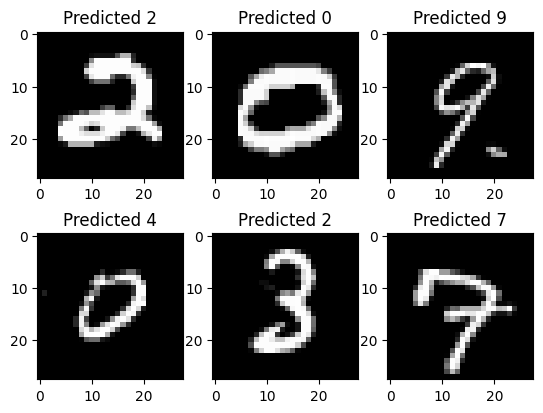

In [24]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1